In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import configparser
import os
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import scipy
from IPython.display import Image, display_png

%matplotlib inline

28-ID - VKB Pitch Motor Resolution: 2e-05 deg
Qt5Agg: unable to import specified backend (or its dependency); no plots


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.
Traceback (most recent call last):
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot.py", line 57, in uti_plot_init
    _backend = uti_plot_matplotlib.Backend(backend, fname_format)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 27, in __init__
    backend = self._init_ipython(backend)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 724, in _init_ipython
    get_ipython().magic('matplotlib ' + b)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.

#### Reference best focus manual

In [3]:
exp_type = 'fwhm'

In [4]:
#base_dir = Path(aps.__file__).parents[1]
#autoalign_dir = base_dir / f'work_directory/28-ID/AI/autoalignment/'
autoalign_dir = Path("/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing")
data_base_dir = autoalign_dir / exp_type
print(f'data base dir exists {data_base_dir.exists()}')


data base dir exists True


In [5]:
data_base_dir

PosixPath('/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing/fwhm')

### peak_lwsi_150_2022-11-19

In [6]:
!ls $data_base_dir

fwhm_moo_150_2022-11-20_images
fwhm_moo_150_2022-11-20_steps
fwhm_moo_autofocusing.ini
fwhm_moo_optimization_final_150_2022-11-20_20:13.gz


Reference best focus


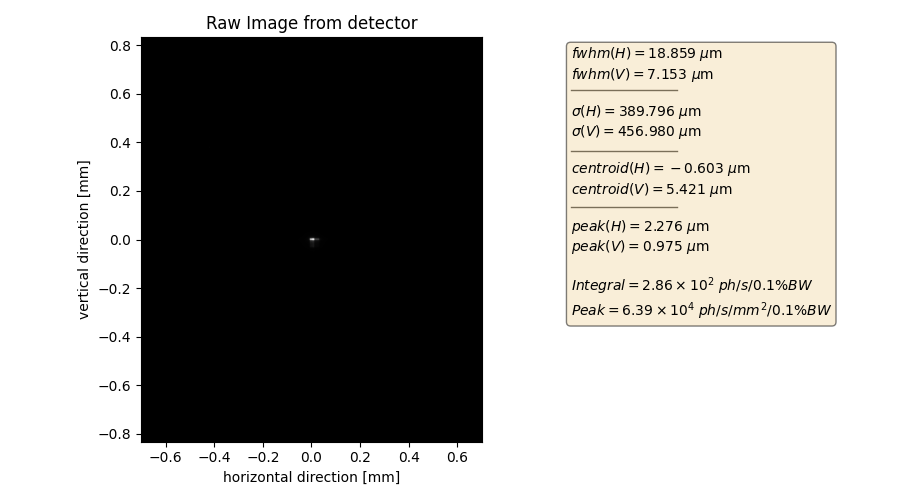

In [7]:
print("Reference best focus")
reference = Image(filename=autoalign_dir / 'Reference_Best_Focus_Manual.png')
display_png(reference)

#### Experiment results

In [8]:
!ls $data_base_dir

fwhm_moo_150_2022-11-20_images
fwhm_moo_150_2022-11-20_steps
fwhm_moo_autofocusing.ini
fwhm_moo_optimization_final_150_2022-11-20_20:13.gz


In [81]:
log_file = Path(data_base_dir / 'fwhm_moo_optimization_final_150_2022-11-20_20:13.gz')
log_file.exists()

True

In [82]:
hist_dir = Path(data_base_dir / 'fwhm_moo_150_2022-11-20_steps')
hist_dir.exists()

True

In [83]:
study = analysis.create_study_from_trials(log_file, directions=['minimize'])

[I 2022-11-21 00:02:16,779] A new study created in memory with name: no-name-340f0dca-2b5a-48b9-bec8-f40b201fdd13


Number of objectives is ignored if directions are supplied.


In [84]:
n_steps = len(study.trials)

In [85]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension='gz')

Trial number 89
Trial values: fwhm 9.601e-03
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.399234965764686, 'h_fwhm': 0.008453913849004735, 'h_centroid': -0.010319011516745802, 'h_peak': -0.2604455766558592, 'v_sigma': 0.4656113203917366, 'v_fwhm': 0.004551778038296428, 'v_centroid': -0.00030176745170834574, 'v_peak': 0.1498835482610394, 'integral_intensity': 275.87169983233866, 'peak_intensity': 64963.5, 'gaussian_fit': {}}}


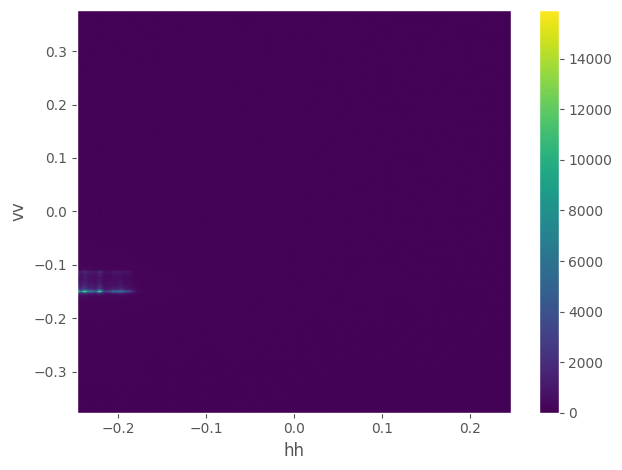

In [86]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: fwhm {t.values[0]:4.3e}")
    print("Trial dw:")
    print(t.user_attrs["dw"].__dict__)
    hist = hists[t.number]
    plt.pcolormesh(hist.hh[700:-700], hist.vv[700:-700], hist.data_2D[700:-700,700:-700].T)
    plt.xlabel('hh')
    plt.ylabel('vv')
    plt.tight_layout()
    plt.colorbar()
    plt.show()

Result: Seems like the beam is too spread out in all the cases.

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_86203/659668950.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="fwhm")


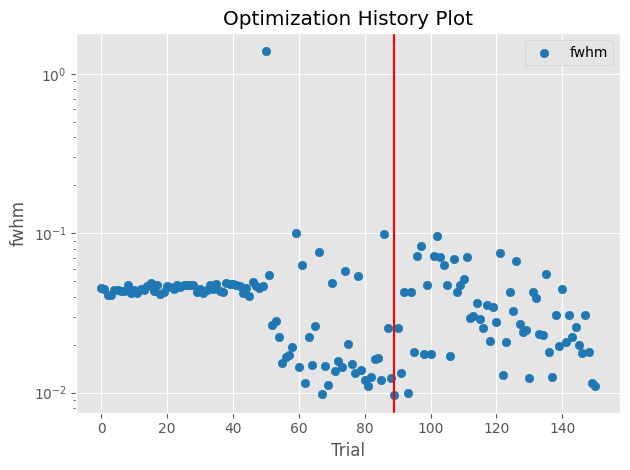

In [87]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="fwhm")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.yscale('log')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_86203/1006208172.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: opt_common._get_peak_distance_from_dw(t.user_attrs['dw']),


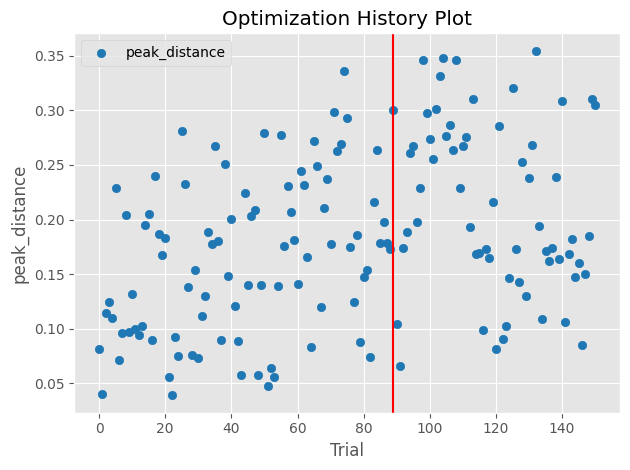

In [89]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: opt_common._get_peak_distance_from_dw(t.user_attrs['dw']),
                                                          target_name="peak_distance")
for t in study.best_trials:
    plt.axvline(t.number, color='red')

plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [75]:

wsums_no_thres = []
wsums_thres = []
for h in hists:
    wsum1 = opt_common._get_weighted_sum_intensity_from_hist(h, crop_distance=0.5)
    _, wsum2 = analysis.calculate_weighted_sum(h)
    wsums_no_thres.append(wsum1)
    wsums_thres.append(wsum2)
    wsums_no_crop.append(wsum0)

wsums_no_thres = np.array(wsums_no_thres)
wsums_thres = np.array(wsums_thres)
                      

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_86203/1383322393.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_no_thres[t.number]),


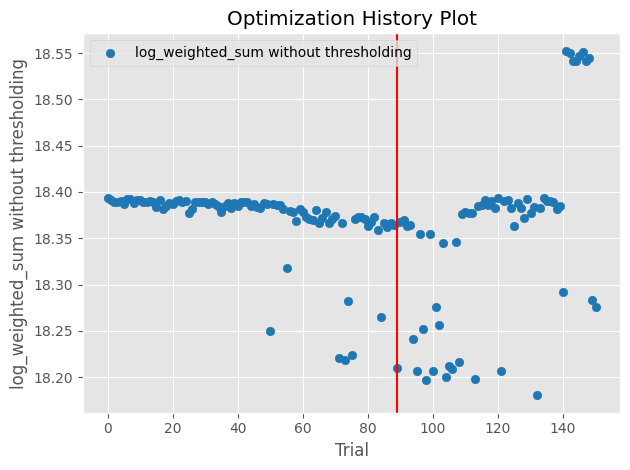

In [76]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_no_thres[t.number]),
                                                          target_name="log_weighted_sum without thresholding")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [77]:
indices = np.argsort(wsums_no_thres)

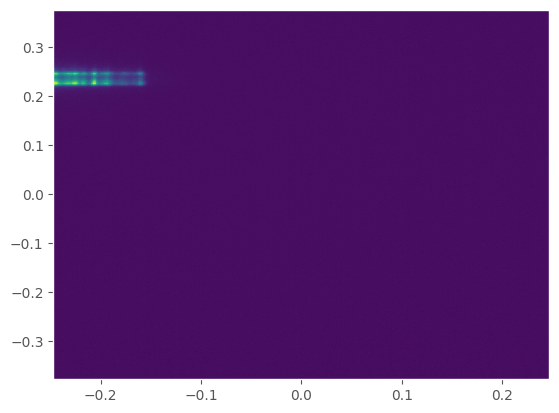

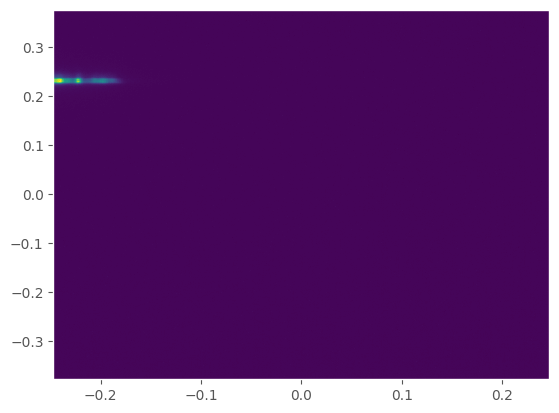

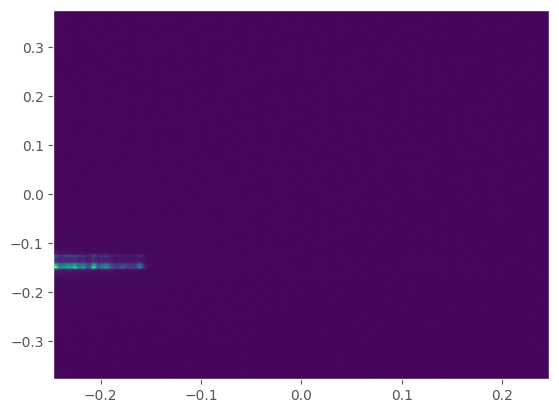

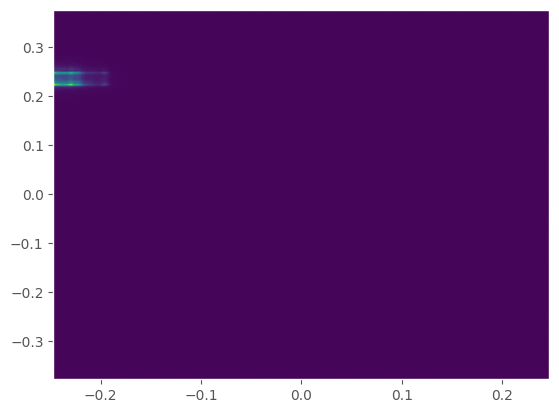

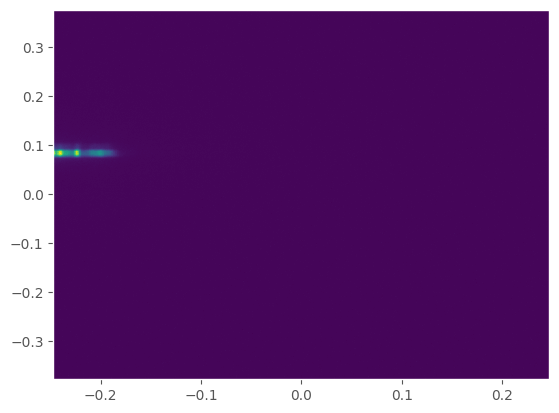

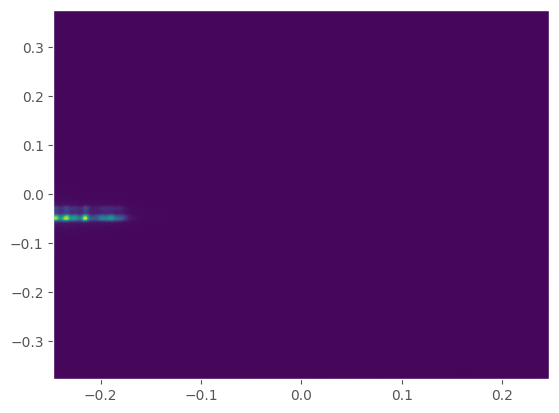

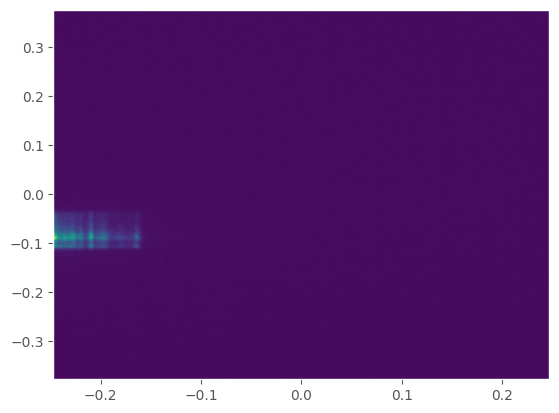

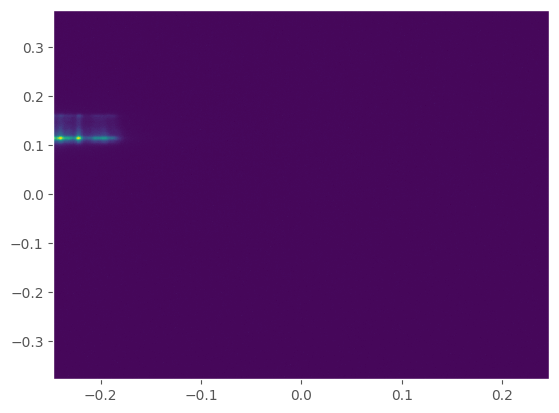

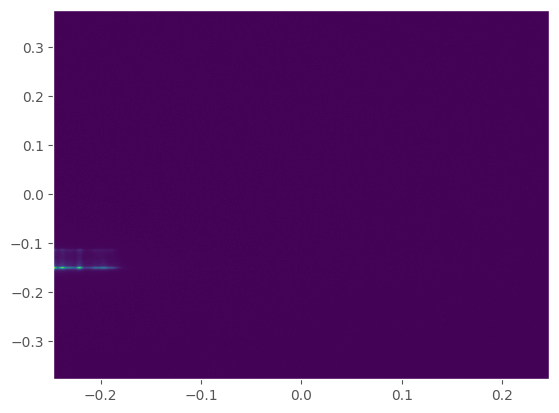

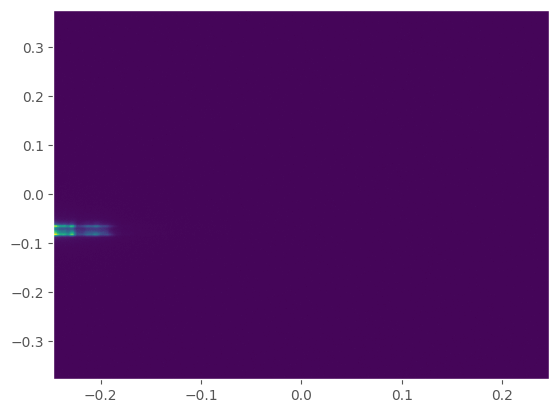

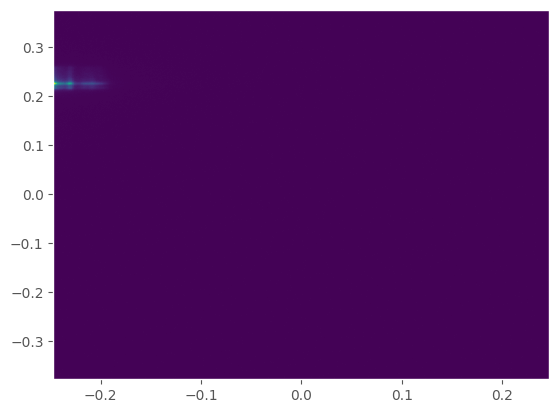

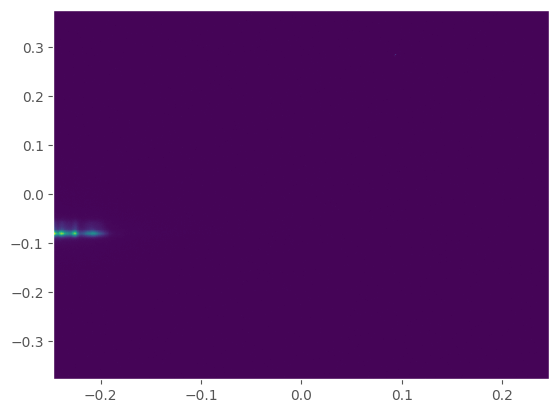

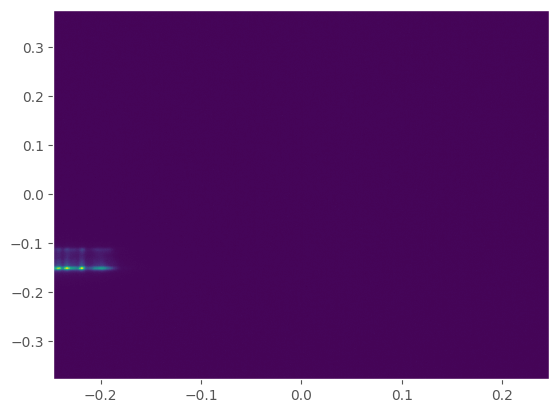

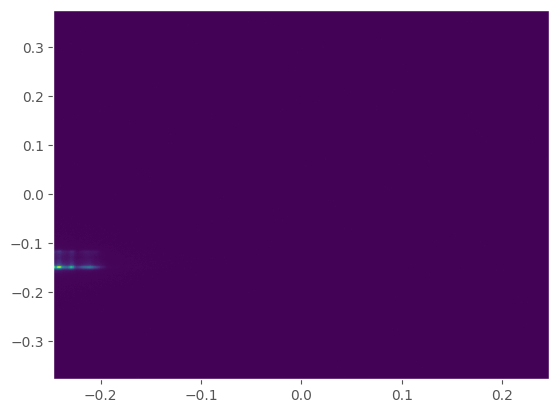

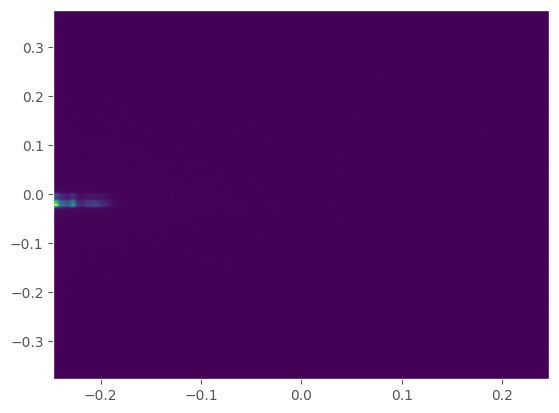

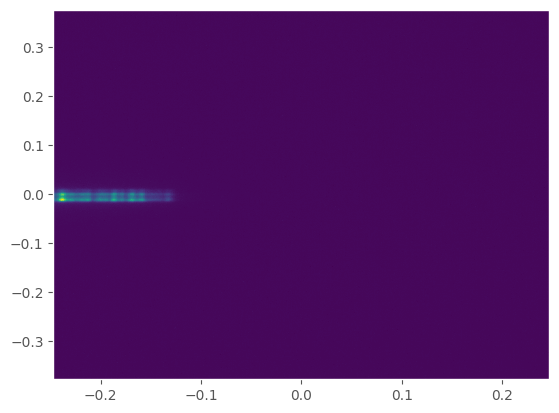

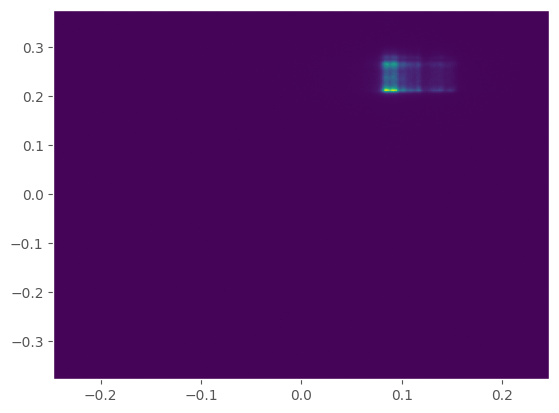

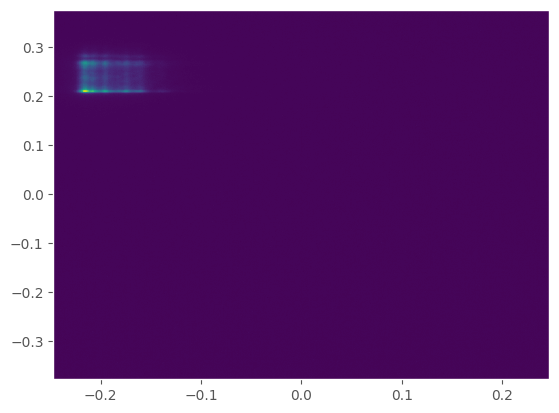

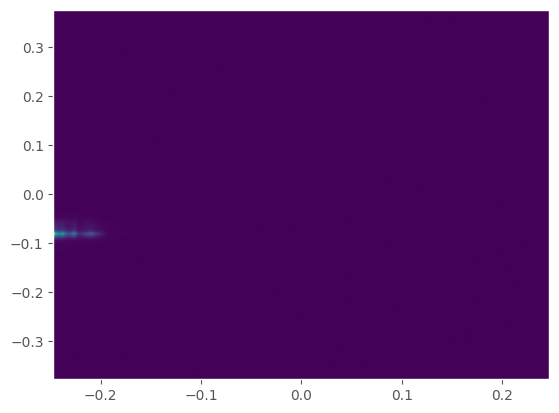

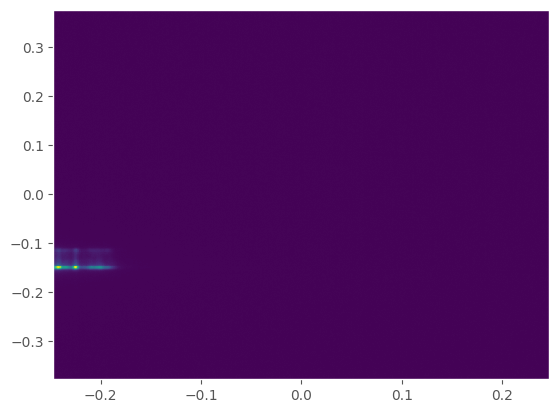

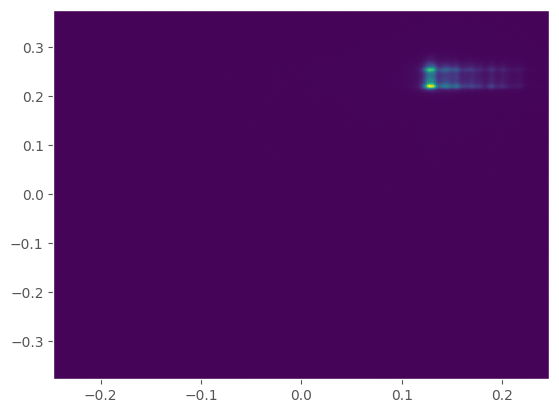

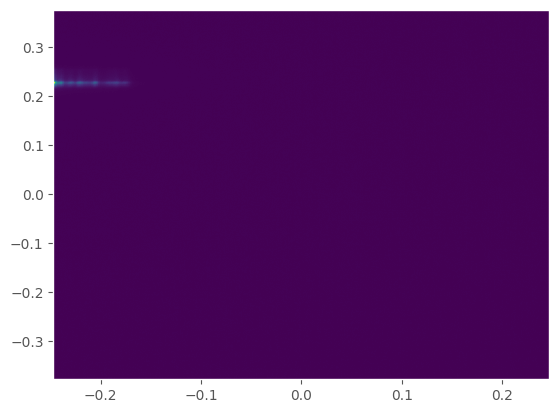

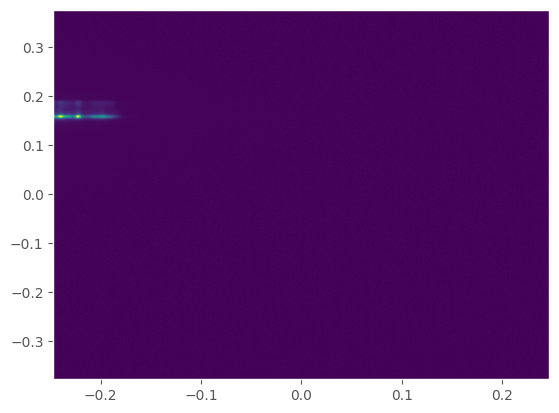

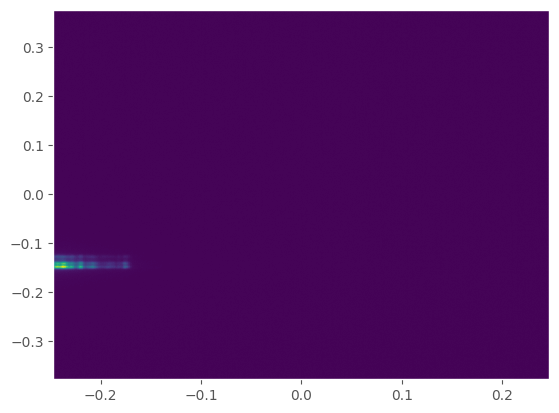

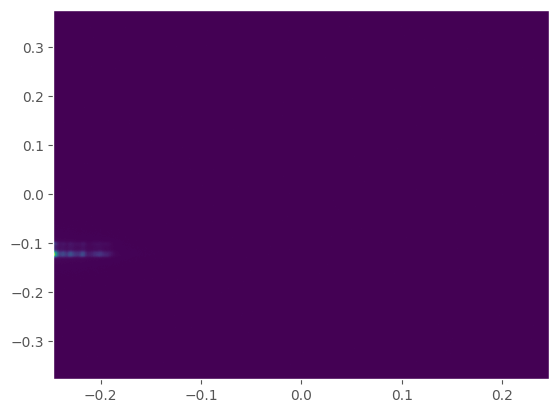

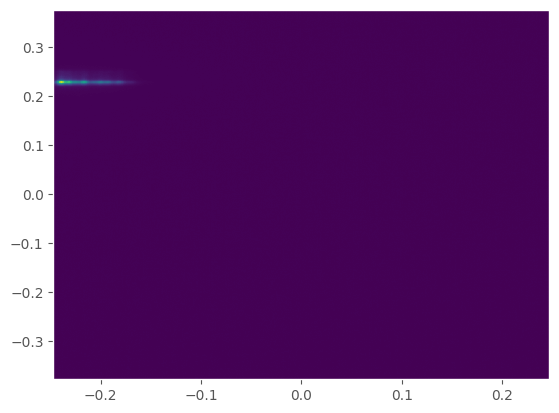

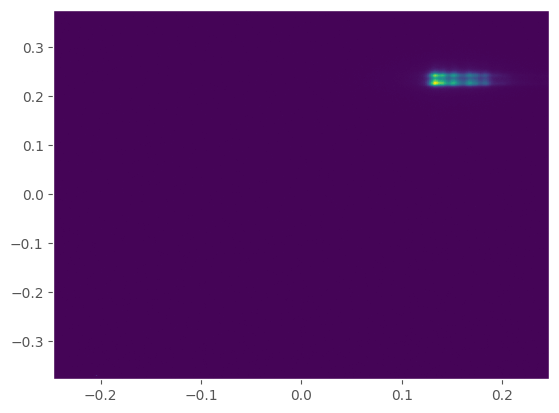

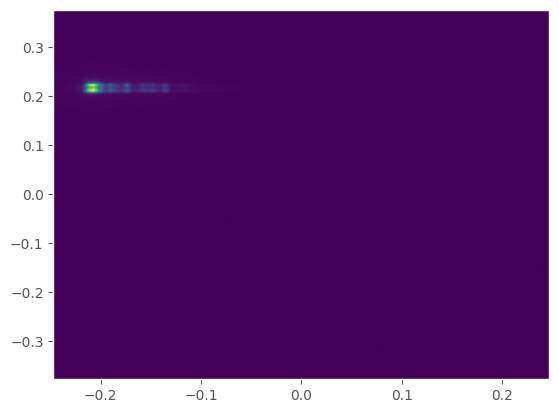

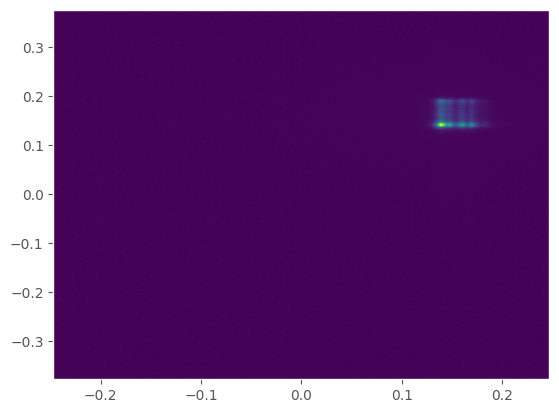

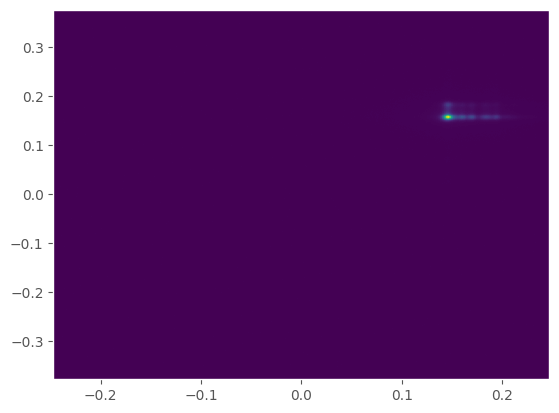

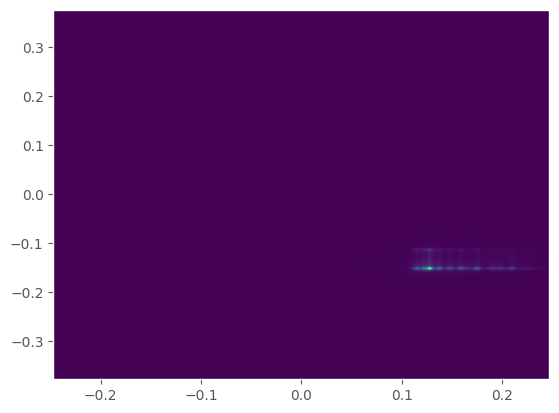

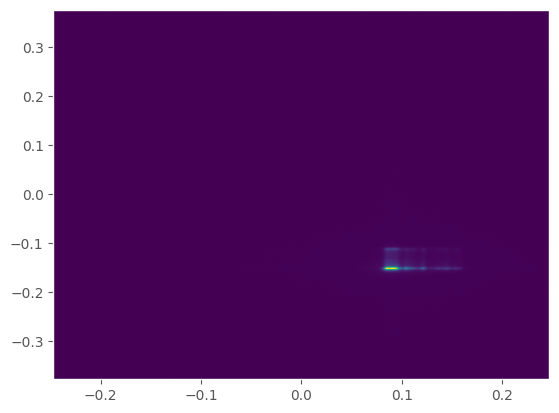

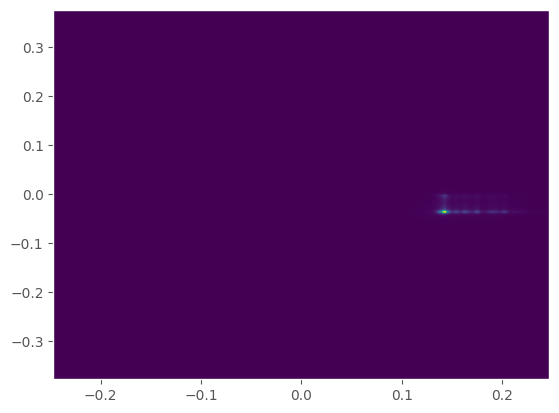

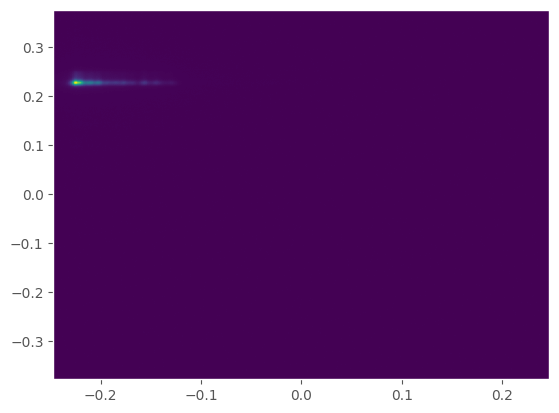

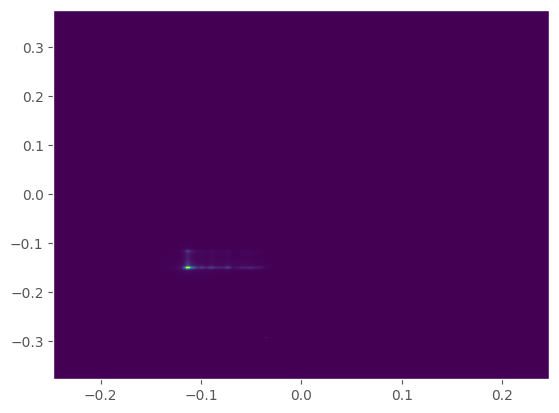

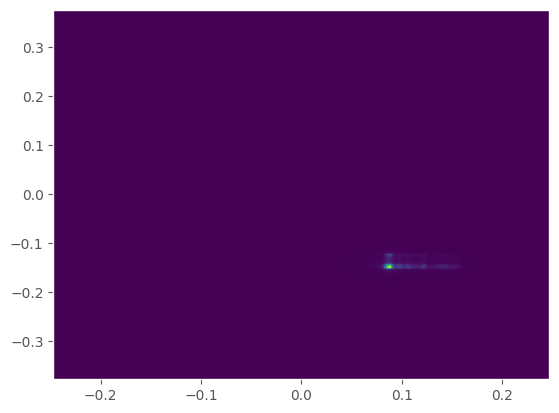

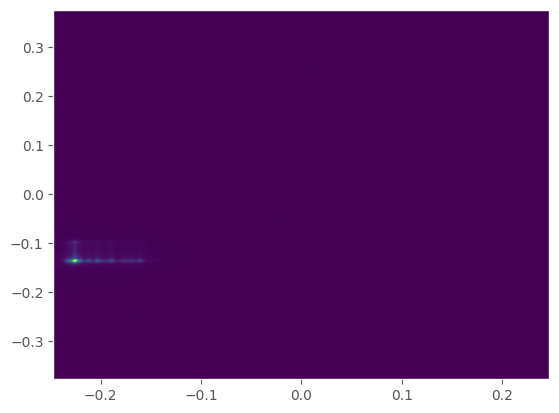

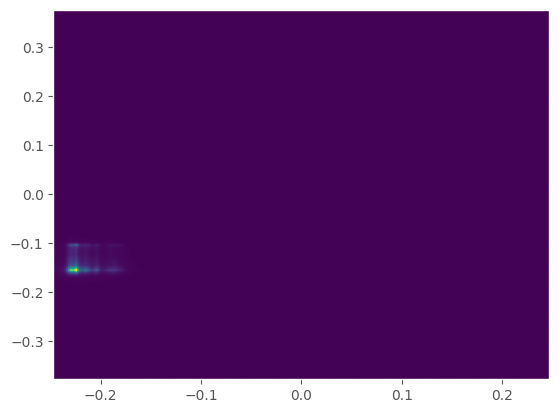

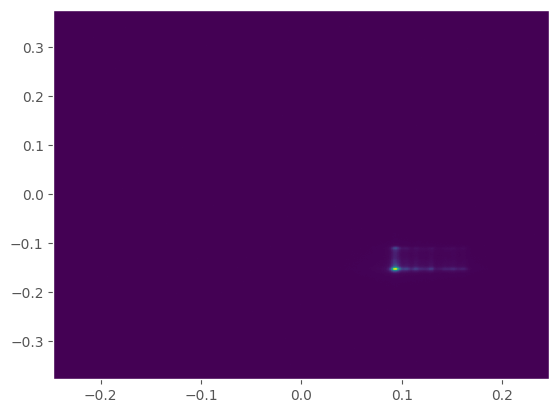

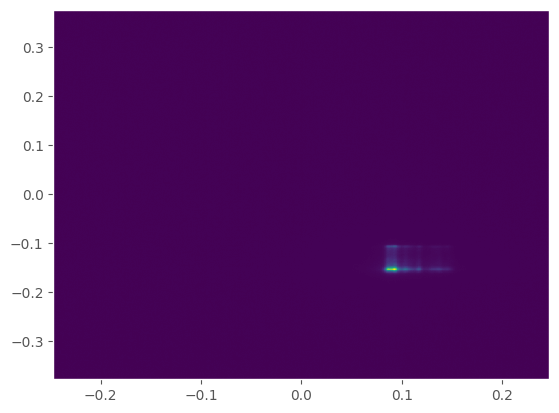

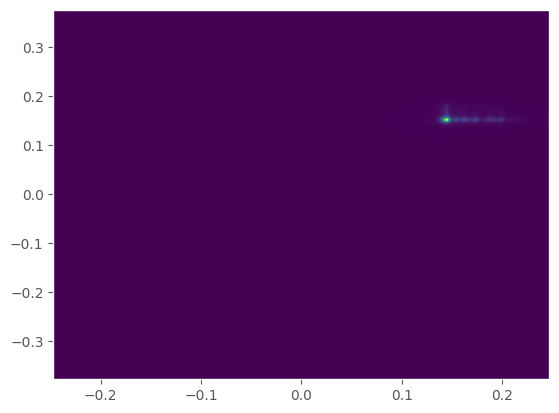

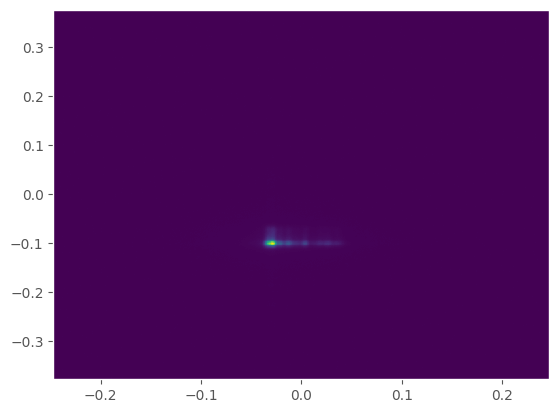

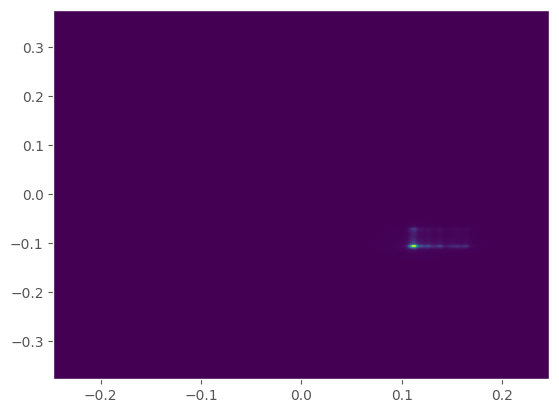

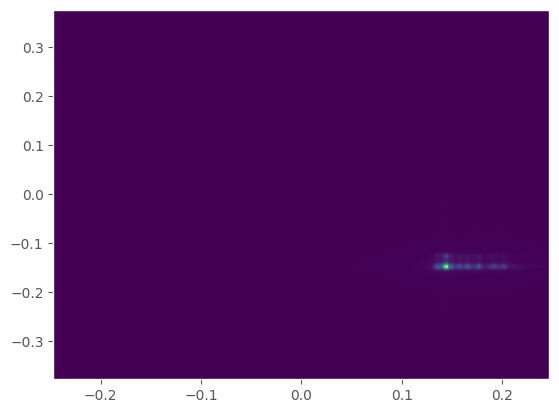

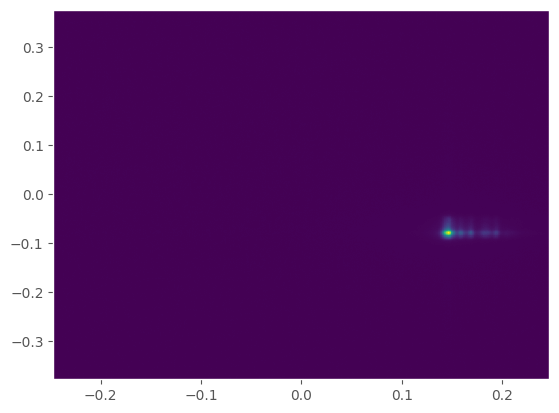

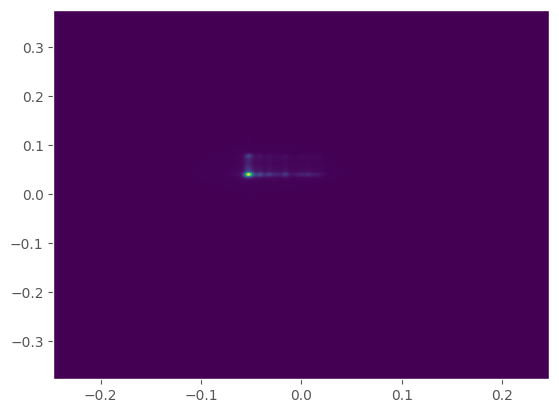

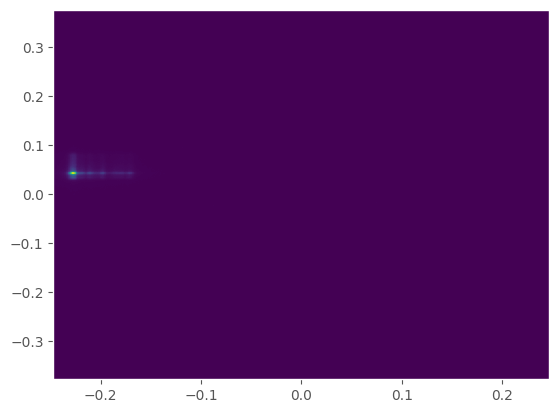

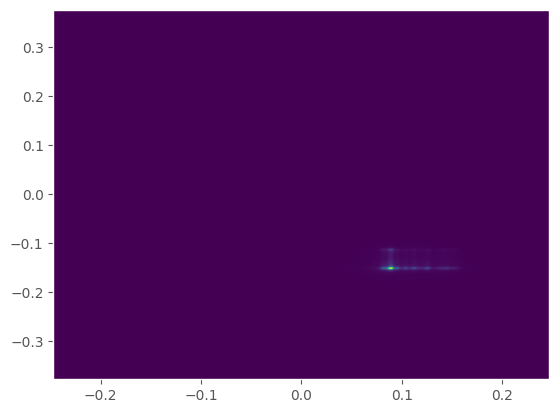

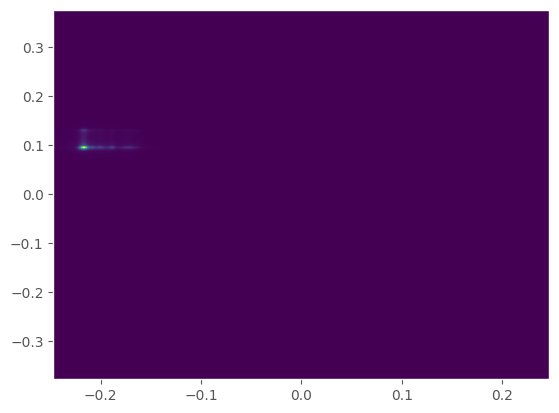

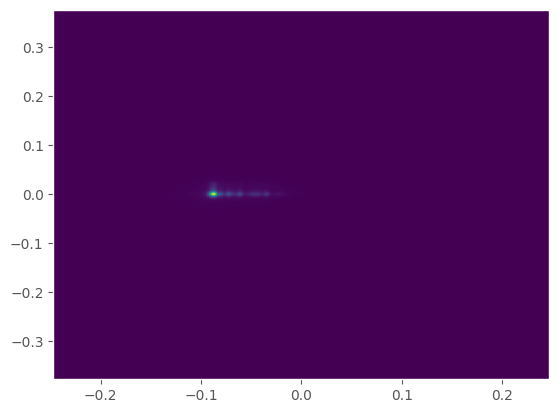

In [79]:
for idx in indices[:50]:
    plt.pcolormesh(hists[idx].hh[700:-700],hists[idx].vv[700:-700][:,None], hists[idx].data_2D[700:-700,700:-700].T)
    plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_86203/4221190599.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_thres[t.number]),


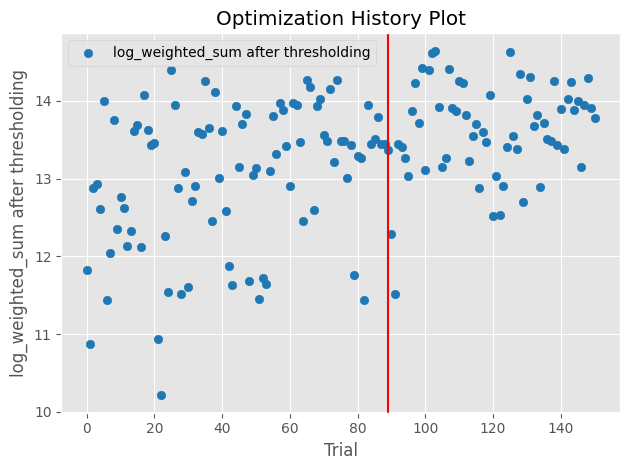

In [56]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_thres[t.number]),
                                                          target_name="log_weighted_sum after thresholding")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [57]:
test_val_fns = [lambda t: t.values[0], lambda t: np.log(wsums_thres[t.number])]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1, 1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1], test_val_fns)
print(np.argmax(domins))

82


1 [0.04444900134170091, 10.871300924042306]


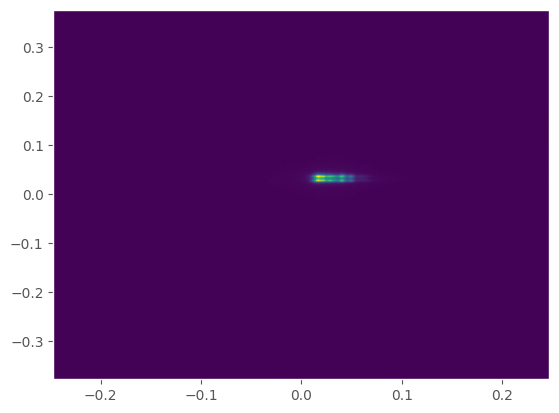

22 [0.044681454806042825, 10.21138000460275]


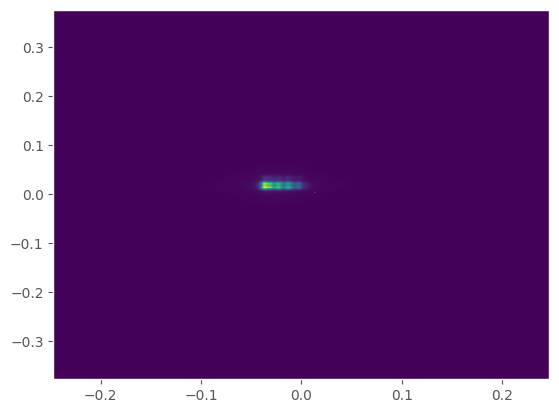

67 [0.009754261862385233, 12.592817027158057]


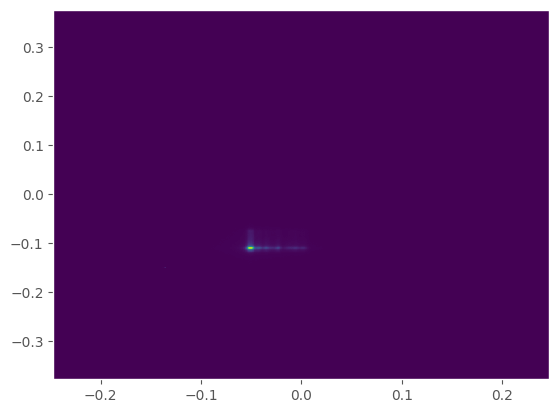

82 [0.012626269465118776, 11.439347521195629]


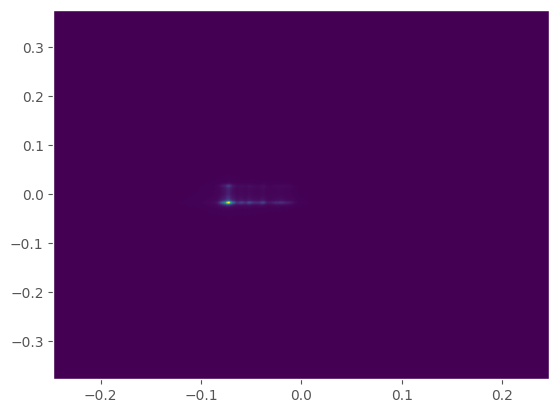

89 [0.009601423992112406, 13.360961952951843]


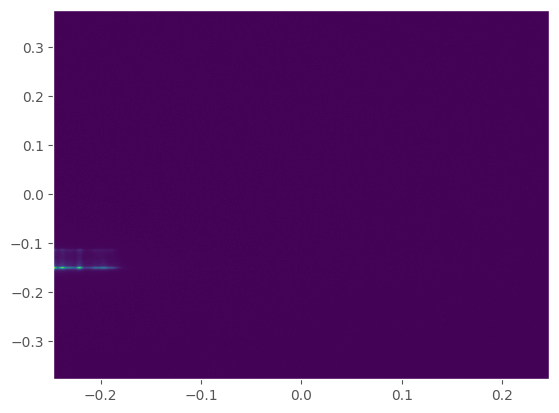

In [58]:
for t in test_pareto:
    print(t.number, test_values[t.number])
    hdata = hists[t.number]
    
    plt.pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T)
    plt.show()

In [56]:
test_val_fns = [lambda t: t.values[0], lambda t: opt_common._get_fwhm_from_dw(t.user_attrs['dw']), lambda t: np.log(wsums_thres[t.number])]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1, 1, 1], values_fns=test_val_fns)

domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1, 1], test_val_fns)
print(np.argmax(domins), domins[np.argmax(domins)])

119 140


24 [0.0048877321579773175, 0.037834539659595816, 9.872197480508158]


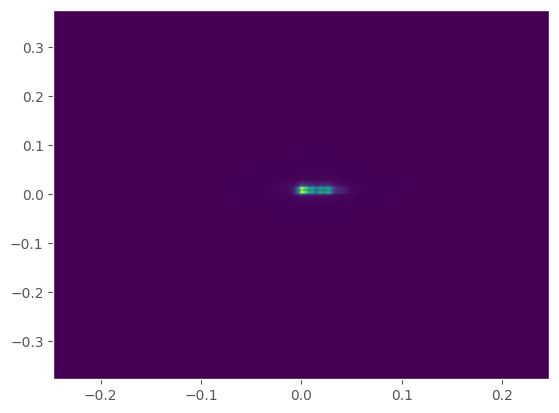

31 [0.003591147252024175, 0.03902303101977523, 9.730177181797615]


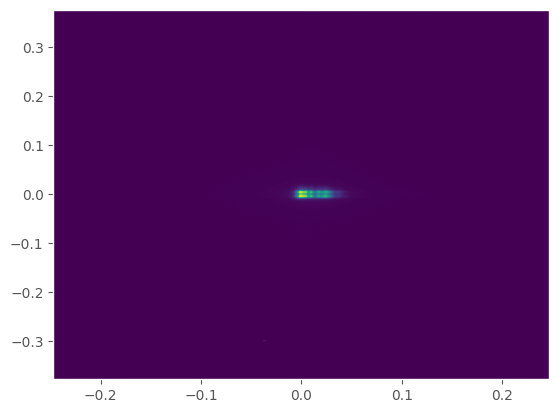

47 [0.004338033304709114, 0.0381073624718826, 9.973196508543614]


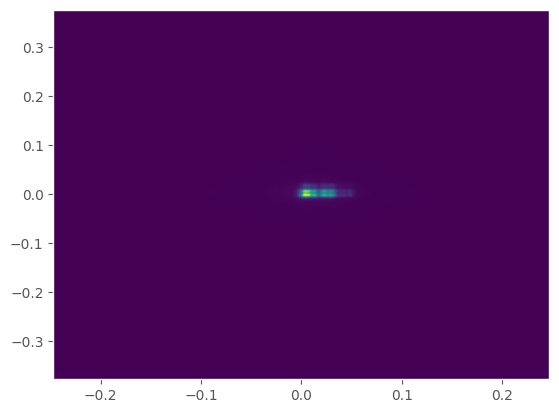

58 [0.025324063159897308, 0.01382502364350689, 10.138000317408826]


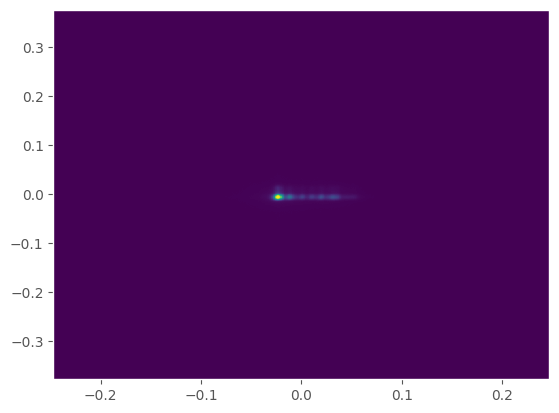

67 [0.006453853459412685, 0.022684799068446875, 11.222073817218536]


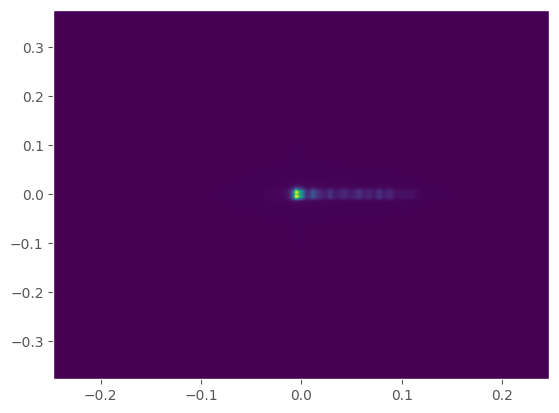

92 [0.003218709586597259, 0.06424164495473672, 10.673057372746362]


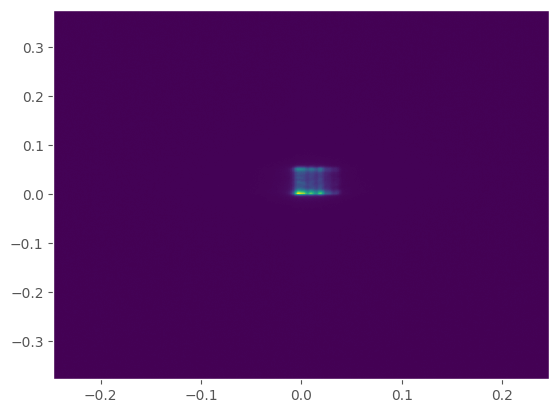

119 [0.006835404912380424, 0.015728404236550825, 9.066711370402402]


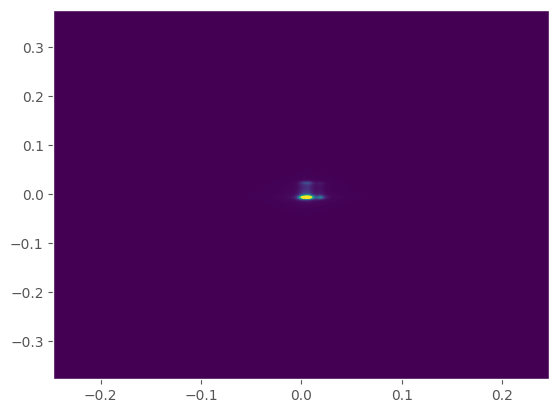

In [57]:
for t in test_pareto:
    print(t.number, test_values[t.number])
    hdata = hists[t.number]
    
    plt.pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T)
    plt.show()